In [1]:
from __future__ import print_function
from fenics import *
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import pylab  
import random

In [2]:
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

(3971, 2)


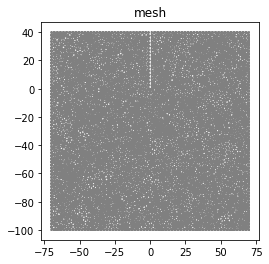

In [3]:
L = 0.5
R = 0.5
N = 50 # mesh density
domain = Rectangle(Point(-70.0,-100.0), Point(70.0, 40.0)) - Rectangle(Point(-1.0,0.0), Point(1.0, 40.95))
mesh = generate_mesh(domain, N)
plot ( mesh, title = 'mesh' )
mesh_points=mesh.coordinates()
print(mesh_points.shape)

In [4]:
Dphi = Constant(1.0)
E = 100000000
nu = 0.3
lmbda = Constant(E*nu/((1+nu)*(1-2*nu))) 
mu = Constant(E/2/(1+nu))

In [5]:
d = 1 # interpolation degree
Vue = VectorElement('CG', mesh.ufl_cell(), d) # displacement finite element
Vp1e = FiniteElement('CG', mesh.ufl_cell(), d) # concentration finite element
Vp2e = FiniteElement('CG', mesh.ufl_cell(), d) # concentration finite element
V = FunctionSpace(mesh, MixedElement([Vue, Vp1e, Vp2e]))

# Boundary conditions
def inner_b(x, on_boundary):
    return near(x[1], -0.0) and on_boundary
def inner_l(x, on_boundary):
    return near(x[0], -1.0) and on_boundary
def inner_r(x, on_boundary):
    return near(x[0], 1.0) and on_boundary
def bottom(x, on_boundary):
    return near(x[1], -100.0) and on_boundary
def left(x, on_boundary):
    return near(x[0], -70.0) and on_boundary
def right(x, on_boundary):
    return near(x[0], 70.0) and on_boundary
def top(x, on_boundary):
    return near(x[1], 40.0) and on_boundary
bc1 = DirichletBC(V.sub(1), Constant(0.), left)
bc2 = DirichletBC(V.sub(1), Constant(0.), right)
bc3 = DirichletBC(V.sub(1), Constant(0.), bottom)
bc4 = DirichletBC(V.sub(2), Constant(0.), left)
bc5 = DirichletBC(V.sub(2), Constant(0.), right)
bc6 = DirichletBC(V.sub(2), Constant(0.), bottom)
bc7 = DirichletBC(V.sub(0).sub(0), Constant(0.), left)
bc8 = DirichletBC(V.sub(0).sub(0), Constant(0.), right)
bc9 = DirichletBC(V.sub(0).sub(0), Constant(0.), bottom)
bc10 = DirichletBC(V.sub(0).sub(1), Constant(0.), left)
bc11 = DirichletBC(V.sub(0).sub(1), Constant(0.), right)
bc12 = DirichletBC(V.sub(0).sub(1), Constant(0.), bottom)

bcs = [bc1,bc2,bc3,bc4,bc5,bc6,bc7,bc8,bc9,bc10,bc11,bc12]

In [6]:
# Defining multiple Neumann boundary conditions 
mf = MeshFunction("size_t", mesh, 1)
mf.set_all(0) # initialize the function to zero
class inner_b(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0) and on_boundary
inner_b = inner_b() # instantiate it
inner_b.mark(mf, 1)
ds = ds(subdomain_data = mf) 

In [7]:
U_ = TestFunction(V)
(u_, P1_, P2_) = split(U_)
dU = TrialFunction(V)
(du, dP1, dP2) = split(dU) 
U = Function(V)
(u, P1, P2) = split(U)

Un = Function(V)
(un, Pn1, Pn2) = split(Un)

In [8]:
d = u.geometric_dimension()
I = Identity(d)             # Identity tensor

F = I + grad(u)             # Deformation gradient
C = F.T * F                # Elastic right Cauchy-Green tensor
Finv = inv(F)
k = 0.1            # Permeability of soil
phi = 0.8
R = 8.32
T = 398

# Invariants of deformation tensors
Ic = tr(C)
J1 = det(F)

ph2 = (1-phi)/(1+(P2+0.001)/(P1+0.001))
ph3 = ph2*(P2+0.001)/(P1+0.001)

F1 = phi* (mu * F - mu * Finv.T + lmbda*ln(J1) * Finv.T) - (P1*R*T* Finv.T) - (P2*R*T* Finv.T)# S

F1 = (1/J1)*F.T * F1

par_psi_phi1 = k*R*T*ph2*grad(P1/(ph2*J1)) # P_p1
par_psi_phi2 = k*R*T*ph3*grad(P2/(ph3*J1)) # P_p2

#  Define time things.
# dt = Constant(0.01)
Tt, num_steps = 550.0 , 50                   
dt = Tt / (1.0*num_steps)

P_init = Expression ( "0.1", degree = 0 )
Pn1 = project ( P_init, V.sub(1).collapse())

P_init1 = Expression ( "0.0", degree = 0 )
Pn2 = project ( P_init1, V.sub(1).collapse())

y_BC = Expression(("0.0", "0.0"),degree=0)
u = project(y_BC,V.sub(0).collapse())

f = Expression(("0.0", "0.0"),degree=0) #Constant((0,-10))
g1 = Expression(("5.0"),degree=0)
g2 = Expression(("10.0"),degree=0)

mech_form = inner(F1, grad(u_))*dx + inner(140*f,u_)*dx
p_form1 = 1*J1*inner(((par_psi_phi1) + 6.5*f), grad(P1_))*dx + ( P1 - Pn1 )*J1/dt * P1_ * dx - J1*g1*P1_*ds(1)
p_form2 = 1*J1*inner(((par_psi_phi2) + 6.5*f), grad(P2_))*dx + ( P2 - Pn2 )*J1/dt * P2_ * dx - J1*g2*P2_*ds(1)

F = mech_form + p_form1 + p_form2 
J = derivative(F, U, dU)

In [9]:
problem = NonlinearVariationalProblem(F, U, bcs, J)
solver  = NonlinearVariationalSolver(problem)

prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-5
prm['newton_solver']['relative_tolerance'] = 1E-3
prm['newton_solver']['maximum_iterations'] = 6
prm['newton_solver']['relaxation_parameter'] = 1.0 

In [10]:
t = 0
for n in range(num_steps):
	print('n=',n)
	t += dt
	print('t=',t)
	solver.solve() # solve(F == 0, X0, bc)   
	    
	(u1, P12, P22) = U.split()

	assign(Un,U)

n= 0
t= 11.0
n= 1
t= 22.0
n= 2
t= 33.0
n= 3
t= 44.0
n= 4
t= 55.0
n= 5
t= 66.0
n= 6
t= 77.0
n= 7
t= 88.0
n= 8
t= 99.0
n= 9
t= 110.0
n= 10
t= 121.0
n= 11
t= 132.0
n= 12
t= 143.0
n= 13
t= 154.0
n= 14
t= 165.0
n= 15
t= 176.0
n= 16
t= 187.0
n= 17
t= 198.0
n= 18
t= 209.0
n= 19
t= 220.0
n= 20
t= 231.0
n= 21
t= 242.0
n= 22
t= 253.0
n= 23
t= 264.0
n= 24
t= 275.0
n= 25
t= 286.0
n= 26
t= 297.0
n= 27
t= 308.0
n= 28
t= 319.0
n= 29
t= 330.0
n= 30
t= 341.0
n= 31
t= 352.0
n= 32
t= 363.0
n= 33
t= 374.0
n= 34
t= 385.0
n= 35
t= 396.0
n= 36
t= 407.0
n= 37
t= 418.0
n= 38
t= 429.0
n= 39
t= 440.0
n= 40
t= 451.0
n= 41
t= 462.0
n= 42
t= 473.0
n= 43
t= 484.0
n= 44
t= 495.0
n= 45
t= 506.0
n= 46
t= 517.0
n= 47
t= 528.0
n= 48
t= 539.0
n= 49
t= 550.0


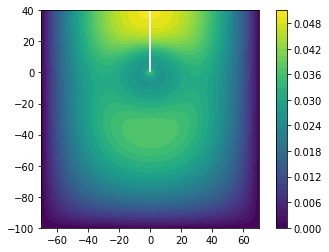

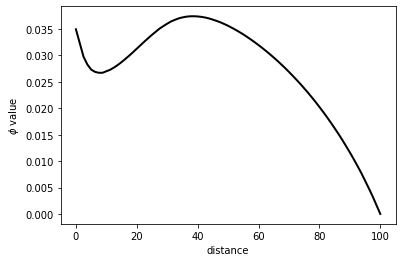

In [11]:
M=plot(P1)
# plt.xlim((-40, 40))
# plt.ylim((-40, 40))
plt.colorbar(M)  
filename = 'Phidistribution.png'
plt.savefig ( filename )
plt.show()

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
# print(points)
u_line = np.array([P1(point) for point in points])
# print(np.max(u_line))
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('$\phi$ value')
plt.xlabel('distance')
plt.show()

np.savetxt('y_rho1.CSV',u_line)
np.savetxt('x.CSV',yy)

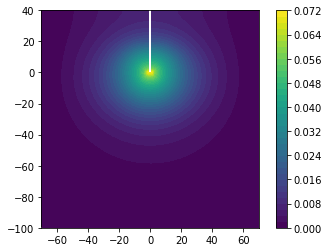

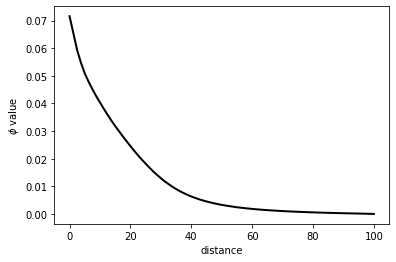

In [12]:
M=plot(P2)
# plt.xlim((-40, 40))
# plt.ylim((-40, 40))
plt.colorbar(M)  
filename = 'Phidistribution.png'
plt.savefig ( filename )
plt.show()

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
# print(points)
u_line = np.array([P2(point) for point in points])
# print(np.max(u_line))
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('$\phi$ value')
plt.xlabel('distance')
plt.show()

np.savetxt('y_rho2.CSV',u_line)
# np.savetxt('x.CSV',yy)

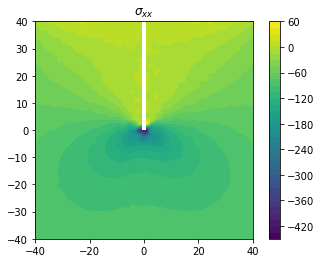

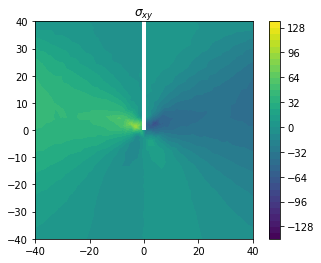

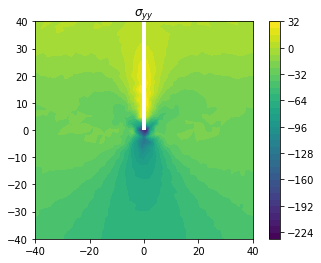

In [13]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)
sigma_w = project(  (phi)* (mu * inv(Finv) - mu * Finv.T + lmbda*ln(det(inv(Finv))) * Finv.T) - (P1*R*T* Finv.T) - (P2*R*T* Finv.T) , W)

M1 = plot(sigma_w[0,0], title='$\sigma_{xx}$')
plt.xlim((-40.0, 40.0))
plt.ylim((-40.0, 40.0))
plt.colorbar(M1)
# plt.contour(M1)
# M1.set_clim(-800,5500)
filename = 'xx.png'
plt.savefig ( filename )
plt.show()


M2 = plot(sigma_w[1,0] ,title='$\sigma_{xy}$')
plt.xlim((-40.0, 40.0))
plt.ylim((-40.0, 40.0))
plt.colorbar(M2)
# M2.set_clim(-1000,1000)
filename = 'xy.png'
plt.savefig ( filename )
plt.show()


M4 = plot(sigma_w[1,1], title='$\sigma_{yy}$')
plt.xlim((-40.0, 40.0))
plt.ylim((-40.0, 40.0))
plt.colorbar(M4)
# M4.set_clim(-500,5000)
filename = 'yy.png'
plt.savefig ( filename )
plt.show()


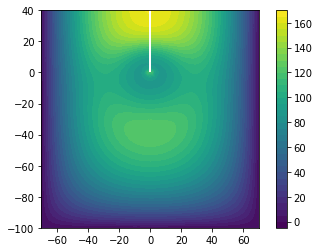

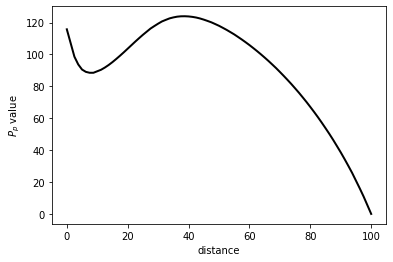

In [16]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)

por_p = project((1/det(inv(Finv)))*P1*R*T*Identity(2) , W)

M5 = plot(por_p[1,1])
# plt.xlim((-40.0, 40.0))
# plt.ylim((-40.0, 40.0))
plt.colorbar(M5)
plt.show()

P0 = por_p[1,1]

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
u_line = np.array([P0(point) for point in points])
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('$P_p$ value')
plt.xlabel('distance')
plt.show()

np.savetxt('y_p1.CSV',u_line)
# np.savetxt('xp.CSV',yy)

por_p1 = por_p[1,1]
p_project = project(por_p1, V.sub(1).collapse())

vtkfile = File('ncomp/1.pvd')
vtkfile << p_project

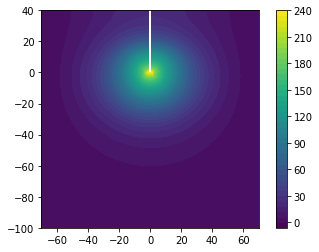

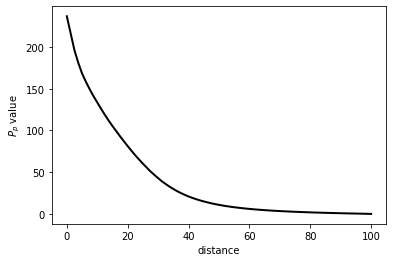

In [17]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)

por_p = project((1/det(inv(Finv)))*P2*R*T*Identity(2) , W)

M5 = plot(por_p[1,1])
plt.colorbar(M5)
plt.show()

P0 = por_p[1,1]

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
u_line = np.array([P0(point) for point in points])
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('$P_p$ value')
plt.xlabel('distance')
plt.show()

np.savetxt('y_p2.CSV',u_line)
# np.savetxt('xp.CSV',yy)

por_p1 = por_p[1,1]
p_project = project(por_p1, V.sub(1).collapse())

vtkfile = File('ncomp/2.pvd')
vtkfile << p_project

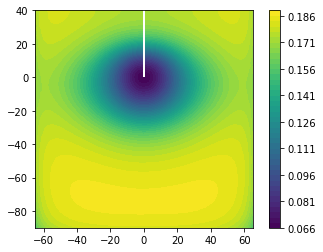

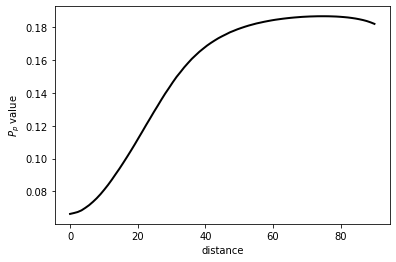

In [17]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)

por_p = project(ph2*Identity(2) , W)

M5 = plot(por_p[1,1])
plt.xlim((-65.0, 65.0))
plt.ylim((-90.0, 40.0))
plt.colorbar(M5)
plt.show()

P0 = por_p[1,1]

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 90.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
u_line = np.array([P0(point) for point in points])
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('$P_p$ value')
plt.xlabel('distance')
plt.show()

np.savetxt('y_phi2.CSV',u_line)
np.savetxt('xp.CSV',yy)

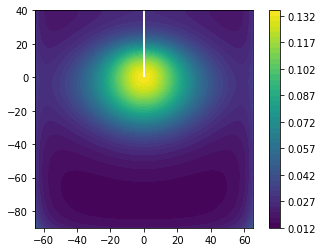

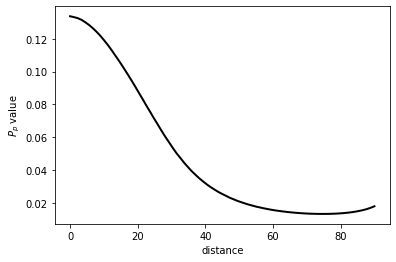

In [18]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)

por_p = project(ph3*Identity(2) , W)

M5 = plot(por_p[1,1])
plt.xlim((-65.0, 65.0))
plt.ylim((-90.0, 40.0))
plt.colorbar(M5)
plt.show()

P0 = por_p[1,1]

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 90.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
u_line = np.array([P0(point) for point in points])
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('$P_p$ value')
plt.xlabel('distance')
plt.show()

np.savetxt('y_phi3.CSV',u_line)
# np.savetxt('xp.CSV',yy)

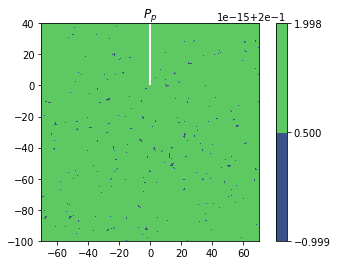

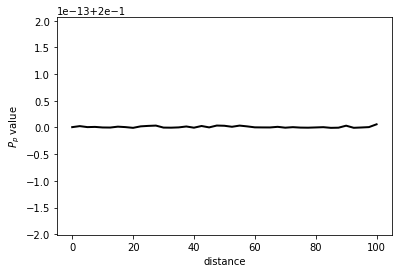

In [19]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)

por_p = project((ph2+ph3)*Identity(2) , W)

M5 = plot(por_p[1,1], title='$P_p$')
plt.colorbar(M5)
plt.show()

P0 = por_p[1,1]

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 41)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
u_line = np.array([P0(point) for point in points])
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('$P_p$ value')
plt.xlabel('distance')
plt.show()

# np.savetxt('yp.CSV',u_line)
# np.savetxt('xp.CSV',yy)